An investigation of ERN's post about Prime Harvesting and random Reddit post

* https://earlyretirementnow.com/2017/04/19/the-ultimate-guide-to-safe-withdrawal-rates-part-13-dynamic-stock-bond-allocation-through-prime-harvesting/
* https://www.reddit.com/r/financialindependence/comments/binb2q/the_clever_market_timing_withdrawal_strategy_an/

Things to test:
* Look more into OmegaNot.
  * Is 100% the best threshold? What about 90%? Or 110%?
  * *Why* does replenish bonds help? Under what circumstances? What exactly does it do?
* ERN's stuff.
  * Look at his McClung-Smooth
  * Replicate his results, why is his glidepath so good?
  * Look beyond just 1966
* Are better results simply caused by higher stock allocations? e.g. a higher SWR might just be due to holding more stocks

In [1]:
import simulate
import withdrawal
import market
import harvesting
import metrics

from decimal import Decimal as D
import decimal
import itertools
import pandas
import numpy
#import ipysheet

In [2]:
%matplotlib inline
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [3]:
run_calc = simulate.calc_lens

In [4]:
# legacy conversion....these functions used to be defined inline,
# now they're in a module. So we import * and splat them in our namespace
from lens import *

In [5]:
Omegas = [harvesting.make_omeganot(D(n)/100) for n in range(70,140, 10)]
Rebalances = [harvesting.make_rebalancer(D(n)/100) for n in range(20, 110, 10)]
Glidepaths = [harvesting.Glidepath, harvesting.InverseGlidepath, harvesting.AgeBased_100]
Harvest_Strategies = Omegas + Rebalances + Glidepaths
Withdraw_Strategies = [
    withdrawal.make_constantdollar(D('.0325')),
    withdrawal.make_constantdollar(D('.035')),
    withdrawal.make_constantdollar(D('.04')),
    withdrawal.make_constantdollar(D('.045')),
    withdrawal.make_constantdollar(D('.05')),
]
Lengths = [30, 40, 50]
Combos = list(itertools.product(Lengths, Harvest_Strategies, Withdraw_Strategies))

In [6]:
PALETTE = seaborn.color_palette("Reds", len(Omegas)) + seaborn.color_palette("YlGn", len(Rebalances)) + seaborn.color_palette("Greys", len(Glidepaths))
seaborn.set_palette(PALETTE)
PALETTE_OMEGAS = seaborn.color_palette("husl", len(Omegas))
PALETTE_HARVEST = seaborn.color_palette("husl", len(Harvest_Strategies))
PALETTE_WITHDRAW = seaborn.color_palette("husl", len(Withdraw_Strategies))

# Failure Rates

In [7]:
def run():
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'Failure Rate'])

    i = 0
    for (years, harvest, withdraw) in Combos:
        s = run_calc(harvest, withdraw, years, calc_success)
        failure_rate = len(s[s == False]) / len(s)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, failure_rate)
        i += 1
    return df
success_df = run()

Text(0.5, 0.98, 'Failure Rates for 40 years')

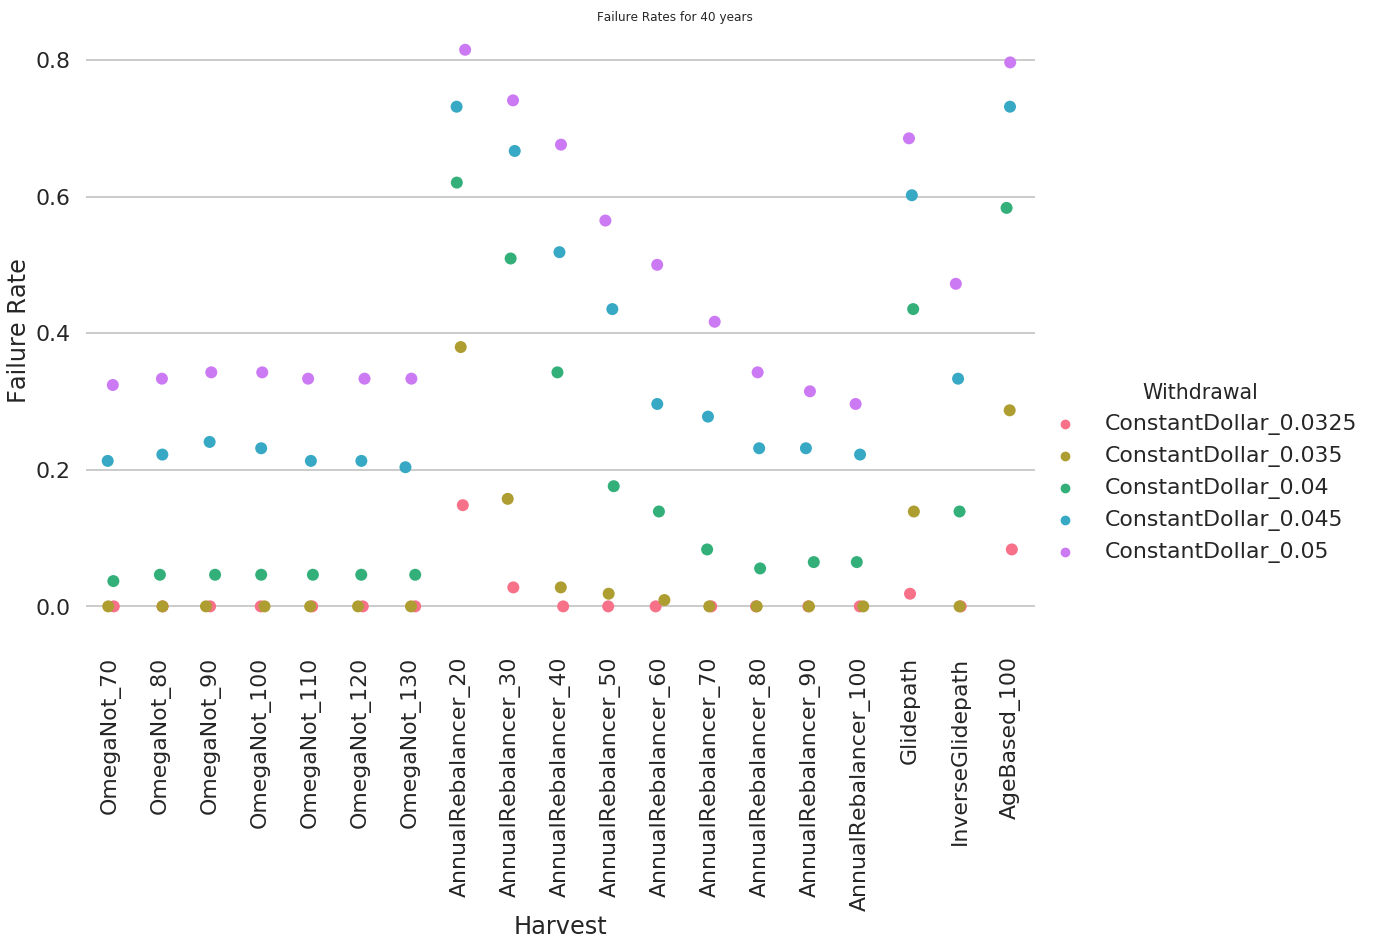

In [8]:
g = seaborn.catplot(x='Harvest',
                    y='Failure Rate',
                    height=10,
                    aspect=1.5,
                    hue='Withdrawal',
                    data=success_df[success_df['Length'] == 40],
                    s=12,
                    palette=PALETTE_WITHDRAW
                )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(rotation=90)
g.fig.suptitle('Failure Rates for 40 years')

Text(0.5, 0.98, 'Failure Rates for 40 years')

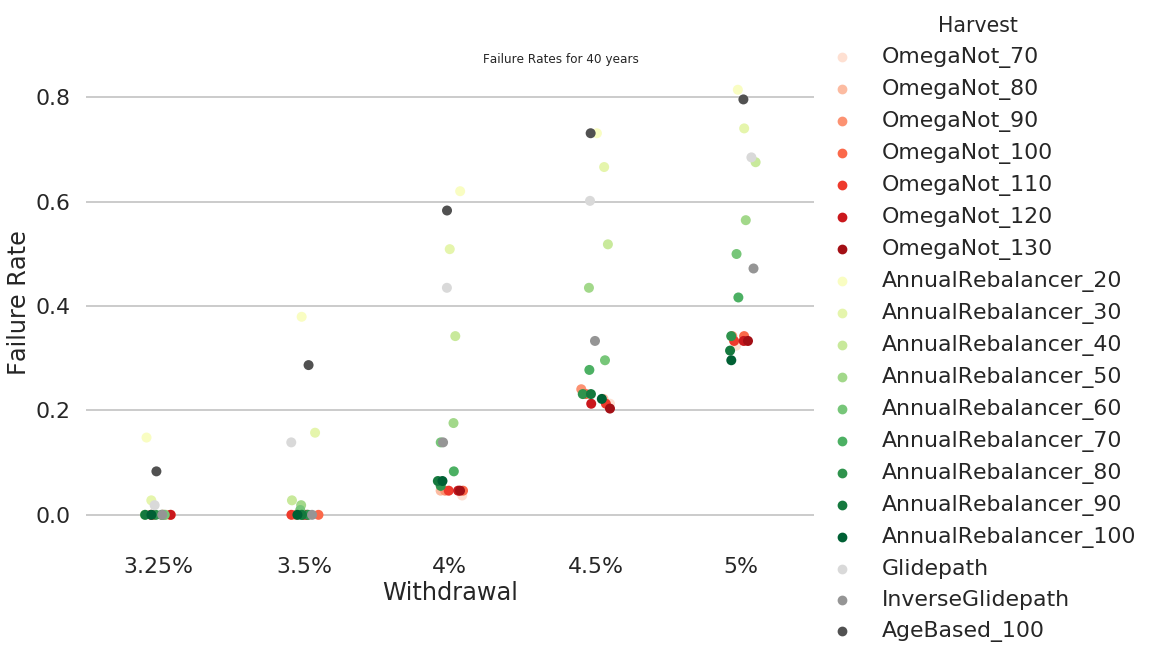

In [9]:
g = seaborn.catplot(x='Withdrawal',
                    y='Failure Rate',
                    height=8,
                    hue='Harvest',
                    data=success_df[success_df['Length'] == 40],
                    aspect=1.5,
                    s=10
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Failure Rates for 40 years')

## Detailed Failure Rate Charts

This generates a lot of charts.
Remove the *break* to re-enable.

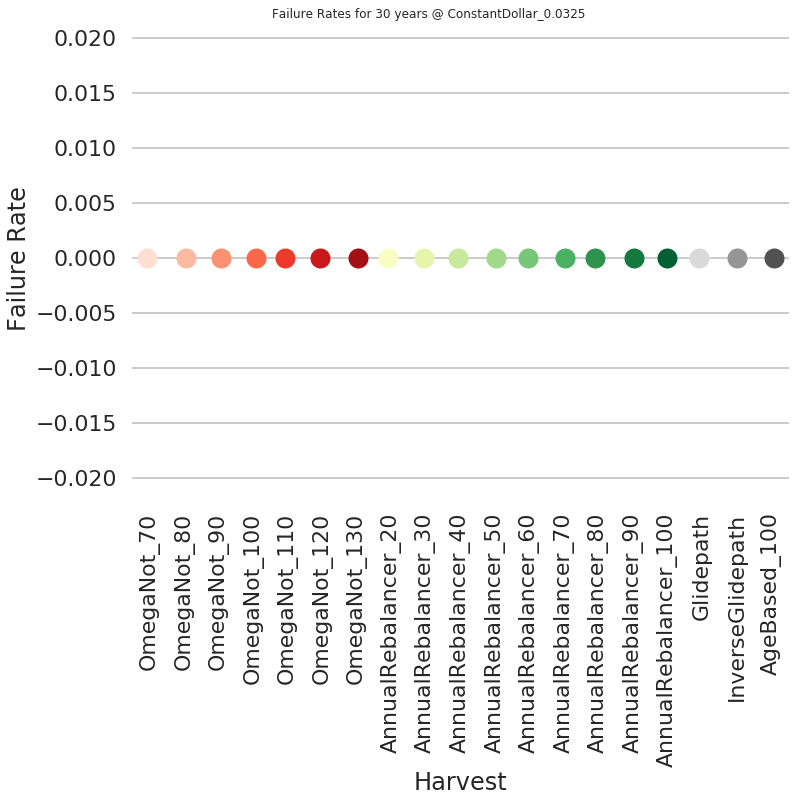

In [10]:
for (years, withdraw) in itertools.product(Lengths, Withdraw_Strategies):
    g = seaborn.catplot(x='Harvest',
                    y='Failure Rate',
                    height=8,
                    data=success_df[(success_df['Length'] == years) & (success_df['Withdrawal'] == withdraw.__name__)],
                    aspect=1.5,
                    s=20
                   )
    g.despine(left=True, bottom=True, offset=20)
    g.set_xticklabels(rotation=90)
    g.fig.suptitle('Failure Rates for %s years @ %s' % (years, withdraw.__name__))
    
    break


# Perfect Withdrawal Amount ($0 remaining)

n.b. PWAs & MSWRs are a weird thing for strategies that shift their asset allocation because the amount that you withdraw changes the asset allocation which in turn changes the MSWR.

So how do you calculate the true MSWR?

Ugh.

In [11]:
PWA_Combos = list(itertools.product(Lengths, Harvest_Strategies, [withdrawal.ConstantPercentage]))
def run():
    df = pandas.DataFrame(index=range(0, len(PWA_Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'PWA'])

    i = 0
    for (years, harvest, withdraw) in PWA_Combos:
        series = run_calc(harvest, withdraw, years, calc_pwa0)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, float(series.min()))
        i += 1
    return df
pwa0_df = run()

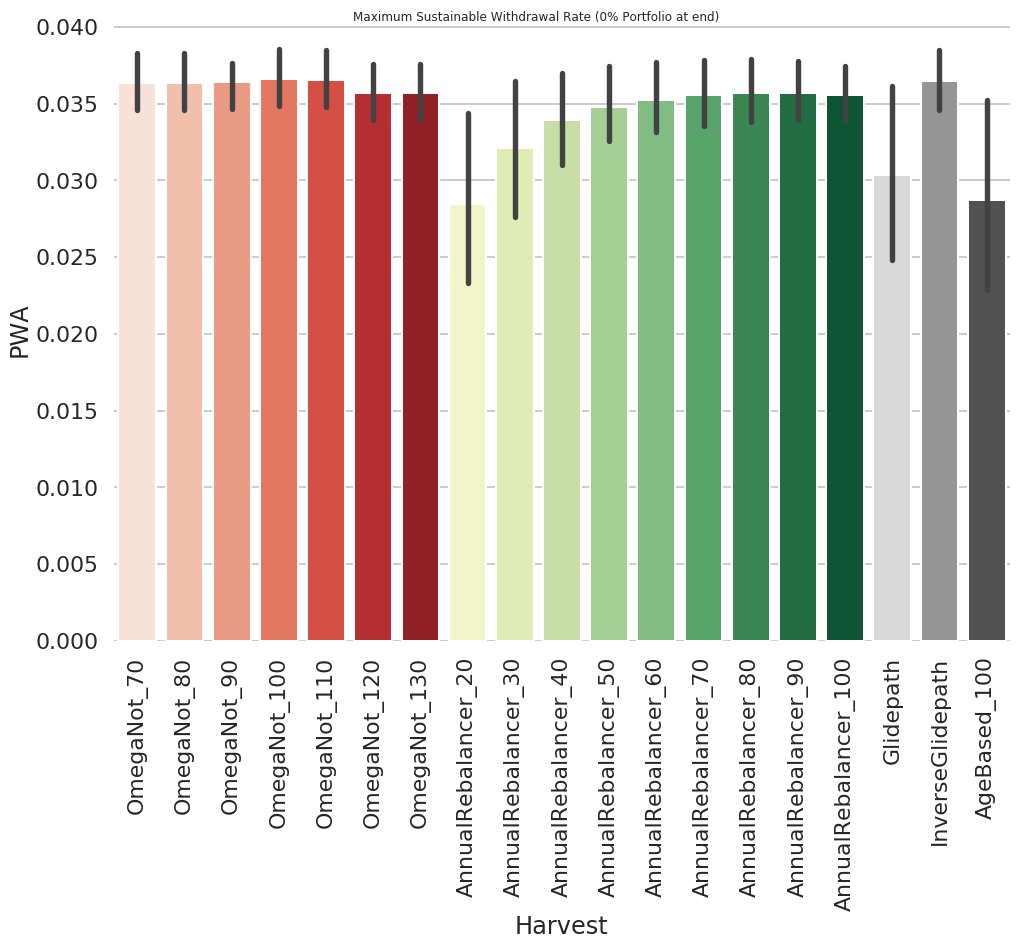

In [12]:
g = seaborn.catplot(x='Harvest',
                    y='PWA',
                    height=10,
                    data=pwa0_df, kind='bar',
                    aspect=1.5
                )
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle('Maximum Sustainable Withdrawal Rate (0% Portfolio at end)')
g.set_xticklabels(rotation=90)

Text(0.5, 0.98, 'Maximum Sustainable Withdrawal Rate (0% Portfolio at end)')

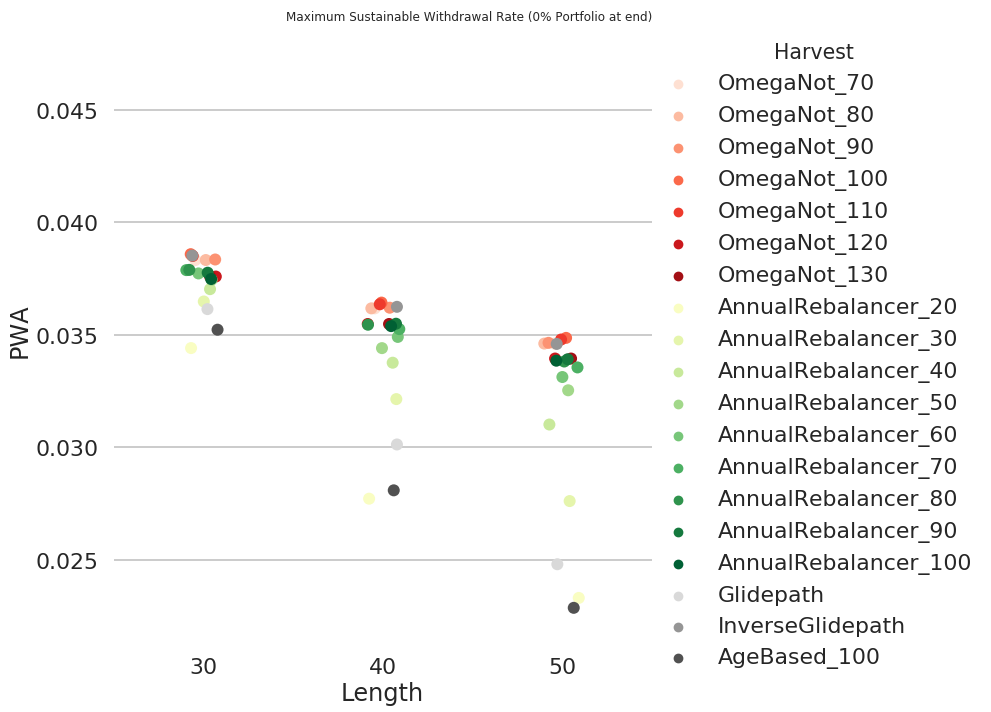

In [13]:
g = seaborn.catplot(x='Length',
                    y='PWA',
                    height=10,
                    s=12,
                    hue='Harvest',
                    data=pwa0_df,
                )
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle('Maximum Sustainable Withdrawal Rate (0% Portfolio at end)')

# Perfect Withdrawal Amount (100% remaining)

In [14]:
def run():
    df = pandas.DataFrame(index=range(0, len(PWA_Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'PWA'])

    i = 0
    for (years, harvest, withdraw) in PWA_Combos:
        series = run_calc(harvest, withdraw, years, calc_pwa1)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.min())
        i += 1
    return df
pwa1_df = run()

Text(0.5, 0.98, 'Maximum Sustainable Withdrawal Rate (100% Portfolio at end)')

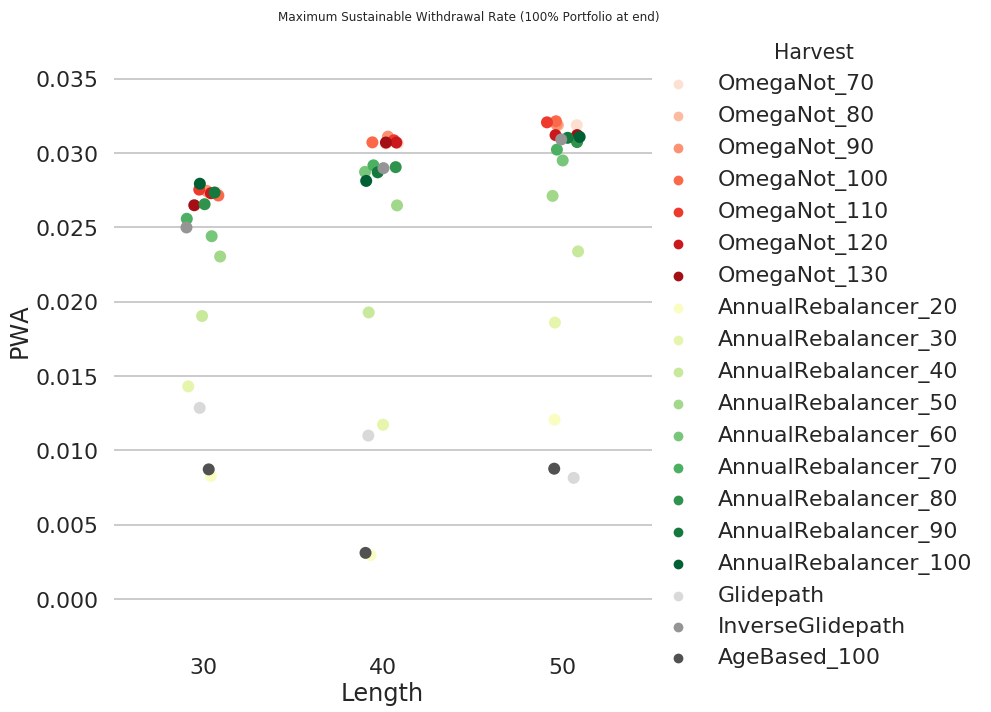

In [15]:
g = seaborn.catplot(x='Length',
                    y='PWA',
                    height=10,
                    s=12,
                    hue='Harvest',
                    data=pwa1_df,
                )
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle('Maximum Sustainable Withdrawal Rate (100% Portfolio at end)')

# Shortfall Years

Shortfall years is the average number of years the strategy fell short, over all the retirement periods in which it failed.

i.e. "when it failed, on averaged it failed N years early"

This is really just a variant on failure rate & that should probably be folder into this.

In [16]:
def run():
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'Shortfall Years'])

    i = 0
    for (years, harvest, withdraw) in Combos:
        series = run_calc(harvest, withdraw, years, calc_shortfall_years)
        shortfalls = series[series > 0]
        shortfall_years = shortfalls.mean()
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, shortfall_years)
        i += 1
    return df
shortfall_years_df = run()

Text(0.5, 0.98, 'Shortfall Years for 40 years')

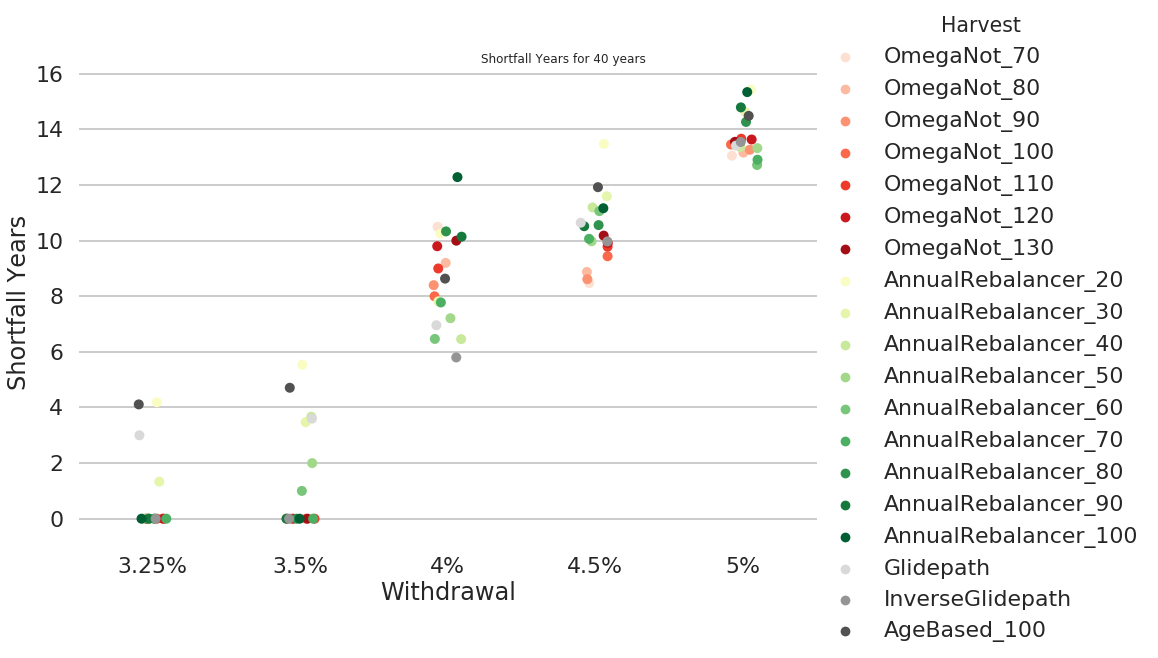

In [17]:
g = seaborn.catplot(x='Withdrawal',
                    y='Shortfall Years',
                    height=8,
                    hue='Harvest',
                    data=shortfall_years_df[shortfall_years_df['Length'] == 40].fillna(0),
                    aspect=1.5,
                    s=10
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Shortfall Years for 40 years')

Text(0.5, 0.98, 'Shortfall Years for 40 years')

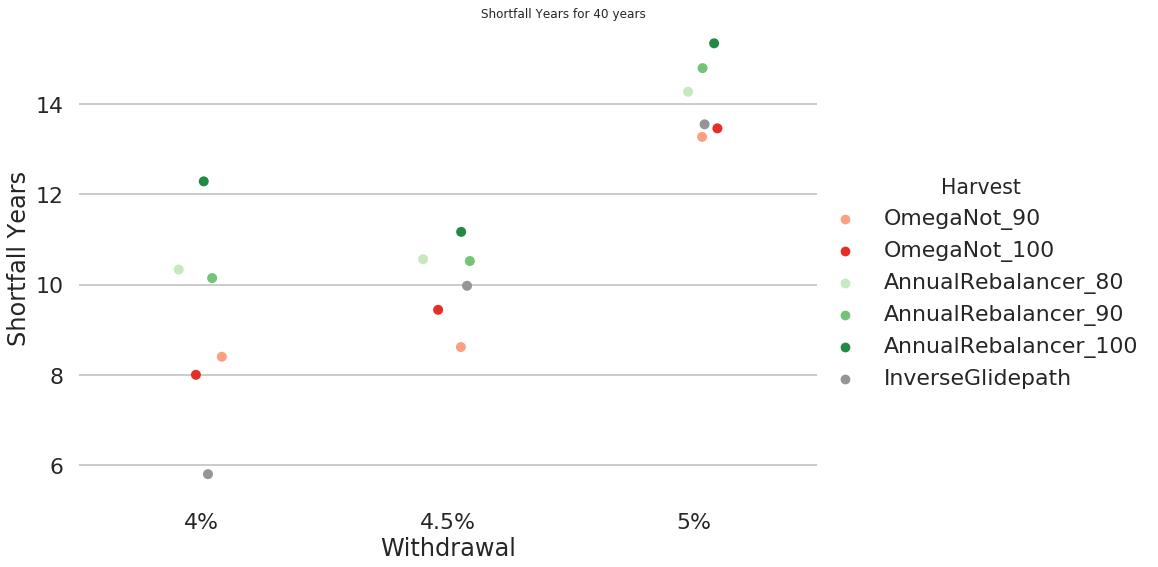

In [18]:
GoodRebalancers = ['AnnualRebalancer_%s' % s for s in [80, 90, 100]]
GoodOmegas = ['OmegaNot_100', 'OmegaNot_90']
GoodGlidepaths = [harvesting.InverseGlidepath.__name__]
FewerHarvests = GoodRebalancers + GoodOmegas + GoodGlidepaths
GoodPalette = (seaborn.color_palette("Reds", len(GoodOmegas))
    + seaborn.color_palette("Greens", len(GoodRebalancers))
    + seaborn.color_palette("Greys", len(GoodGlidepaths)))
HardWithdraws = ['ConstantDollar_0.04', 'ConstantDollar_0.045', 'ConstantDollar_0.05']

g = seaborn.catplot(x='Withdrawal',
                    y='Shortfall Years',
                    height=8,
                    hue='Harvest',
                    data=shortfall_years_df[(shortfall_years_df['Length'] == 40)
                                            & (shortfall_years_df['Harvest'].isin(FewerHarvests))
                                            & (shortfall_years_df['Withdrawal'].isin(HardWithdraws))],
                    aspect=1.5,
                    s=10,
                    palette=GoodPalette
                   )

g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['4%', '4.5%', '5%'])
g.fig.suptitle('Shortfall Years for 40 years')

Text(0.5, 0.98, 'Shortfall Years for 40 years')

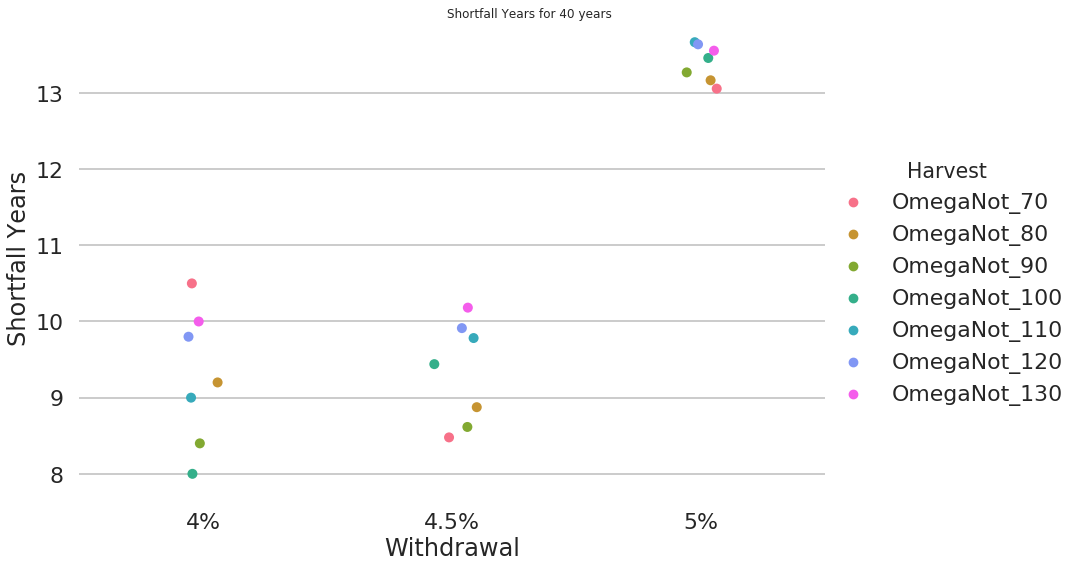

In [19]:
JustOmegas = [n.__name__ for n in Omegas]

g = seaborn.catplot(x='Withdrawal',
                    y='Shortfall Years',
                    height=8,
                    hue='Harvest',
                    data=shortfall_years_df[(shortfall_years_df['Length'] == 40)
                                            & (shortfall_years_df['Harvest'].isin(JustOmegas))
                                            & (shortfall_years_df['Withdrawal'].isin(HardWithdraws))],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_OMEGAS
                   )

g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['4%', '4.5%', '5%'])
g.fig.suptitle('Shortfall Years for 40 years')

# Downside Risk-Adjusted Success & Coverage Ratio

Risk-adjusted success is the ratio between the expected value and the standard deviation of years sustained.

Coverage ratio is the number of years the portfolio lasted, run through a utility function so large values are discount and shortfalls penalized.

In [20]:
def run():
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'D-RAS', 'Coverage Ratio'])

    i = 0
    for (years, harvest, withdraw) in Combos:
        series = run_calc(harvest, withdraw, years, calc_years_sustained)
        
        # how many had shortfall years?
        failures = series[series < 0]
        successes = series[series >= 0]
        p_fail = len(failures) / len(series)        
        L = years
        
        s_y = failures.mean()
        b_y = successes.mean()
        e_ys = (p_fail * (L + s_y)) + ((1 - p_fail) * (L + b_y))
        # semi-deviation with respect to length of retirement
        ssd_l_ys = (p_fail * s_y * s_y) ** 1/2
        
        d_ras = e_ys / ssd_l_ys
        
        # now calculate the coverage ratio
        coverage_series = series.apply(lambda x: (x+L)/L)
        
        def u_c(c, risk_aversion=D('0.9999'), penalty_coeff=D(10)):
            c = D(c)
            if c >= 1:
                numerator = (c ** (1 - risk_aversion)) - 1
                denominator = 1 - risk_aversion
                return numerator / denominator
            else:
                numerator = (1 ** (1 - risk_aversion)) - 1
                denominator = 1 - risk_aversion
                penalty = penalty_coeff * (1 - c)
                return (numerator / denominator) - penalty
        U_C = coverage_series.apply(u_c)
        coverage = U_C.mean()
        
        # the pandas based clipping isn't working so we manually hack it in there.
        # Should really investigate this...why is it so high?
        if d_ras > 5000:
            d_ras = d_ras

        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, d_ras, coverage)
        i += 1
    return df
dras_df = run()

## Downside Risk-Adjusted Success

higher is better

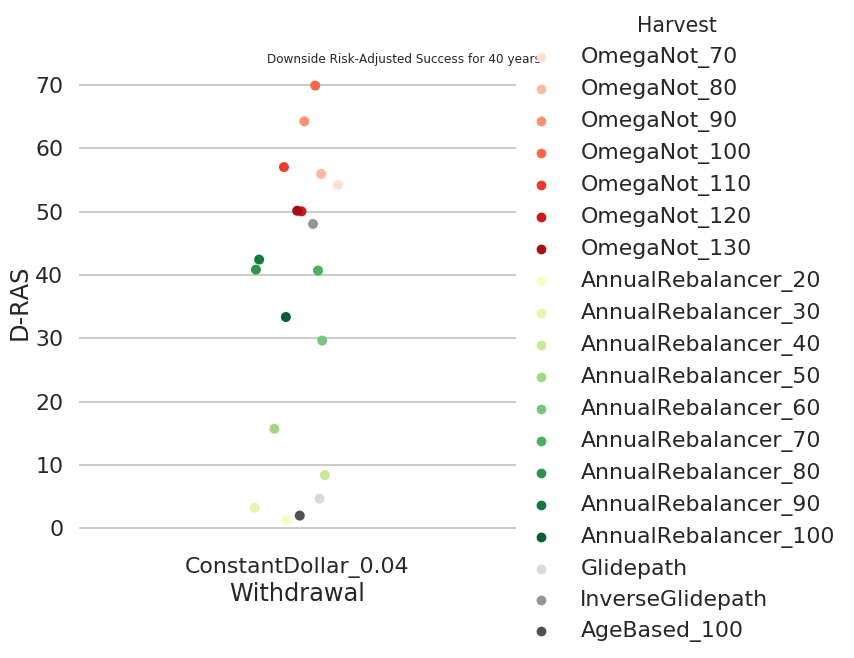

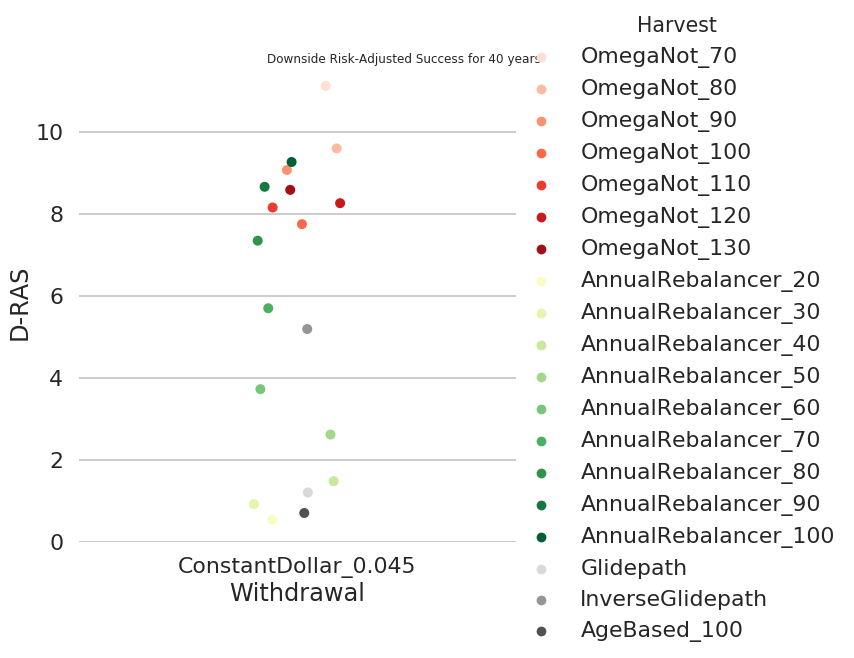

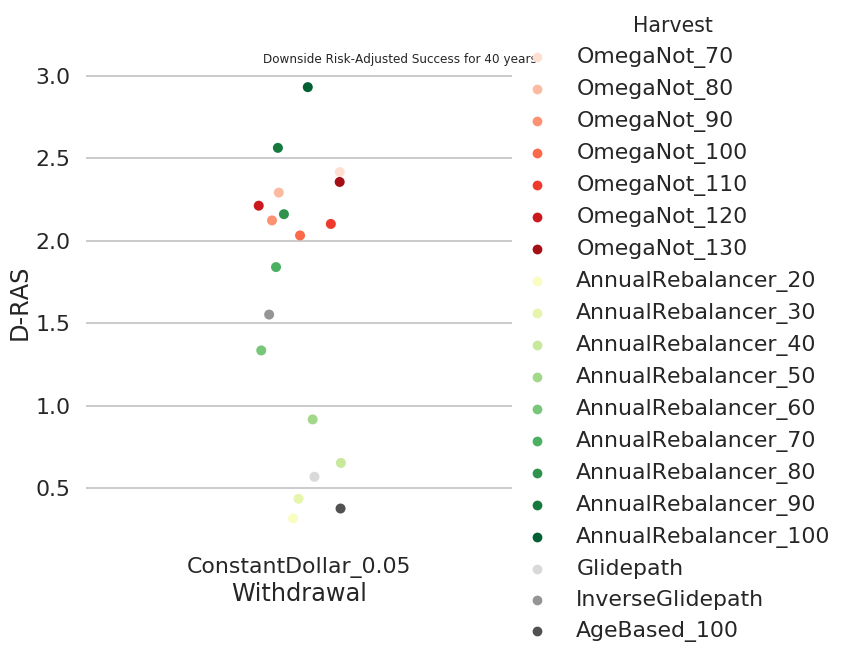

In [21]:
for withdraw in HardWithdraws:
    g = seaborn.catplot(x='Withdrawal',
                        y='D-RAS',
                        height=8,
                        hue='Harvest',
                        data=dras_df[(dras_df['Length'] == 40) & (dras_df['Withdrawal'] == withdraw)],
                        s=10
                       )
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle('Downside Risk-Adjusted Success for 40 years')

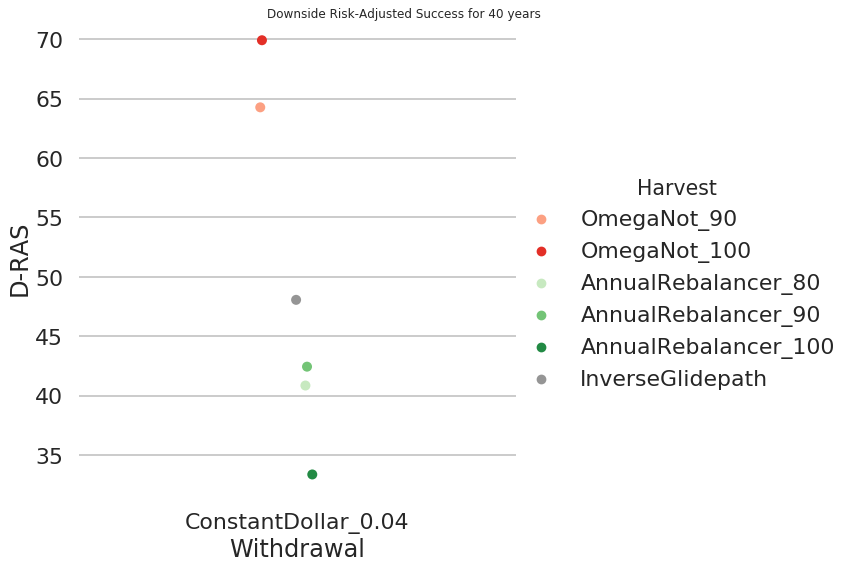

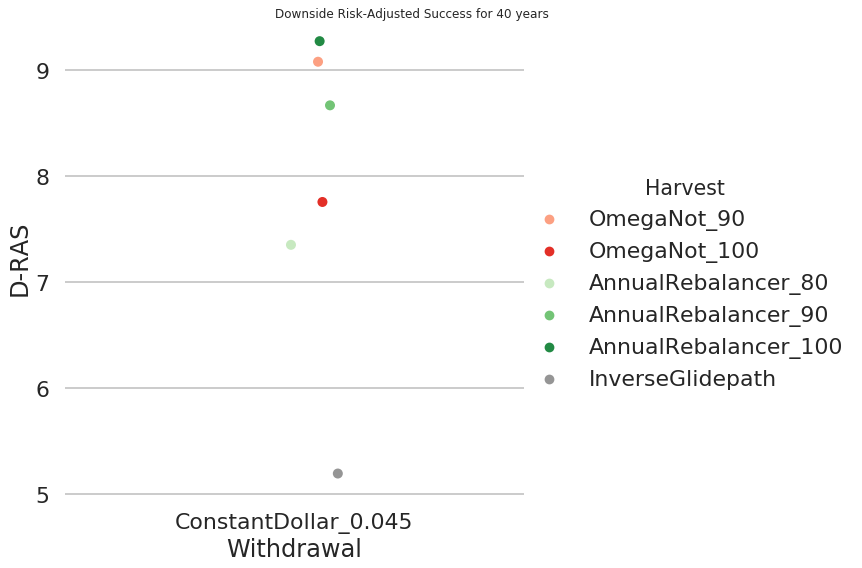

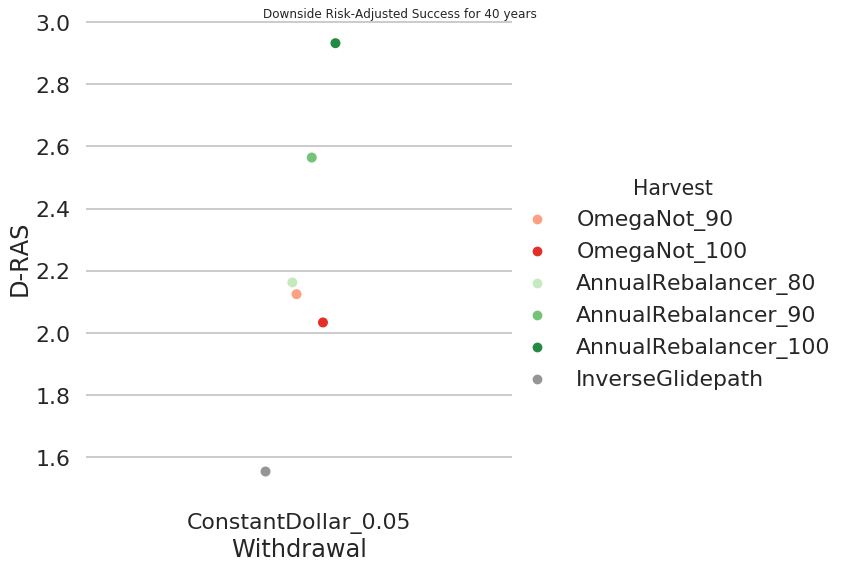

In [22]:
for withdraw in HardWithdraws:
    g = seaborn.catplot(x='Withdrawal',
                        y='D-RAS',
                        height=8,
                        hue='Harvest',
                        data=dras_df[(dras_df['Length'] == 40)
                                     & (dras_df['Harvest'].isin(FewerHarvests))
                                     & (dras_df['Withdrawal'] == withdraw)],
                        s=10,
                        palette=GoodPalette
                       )
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle('Downside Risk-Adjusted Success for 40 years')

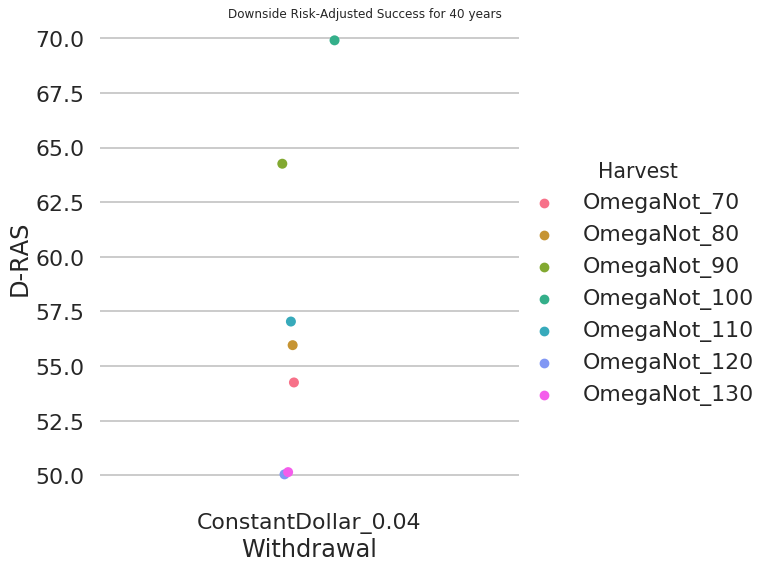

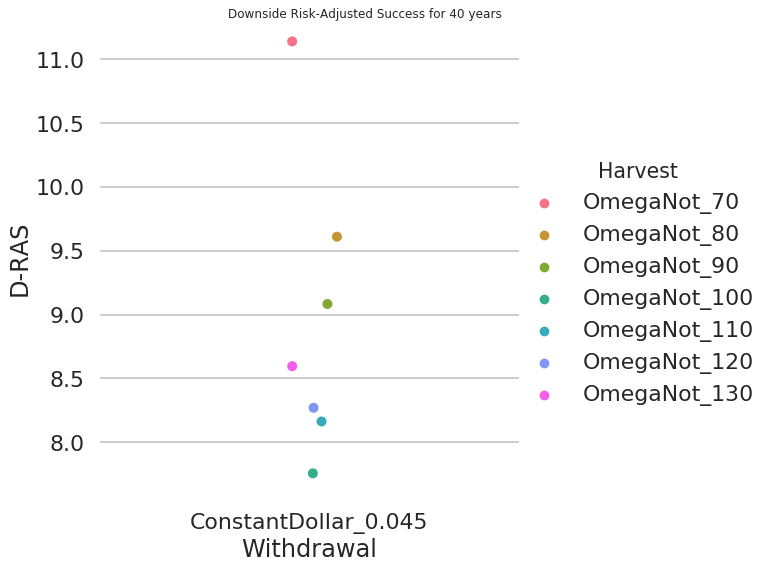

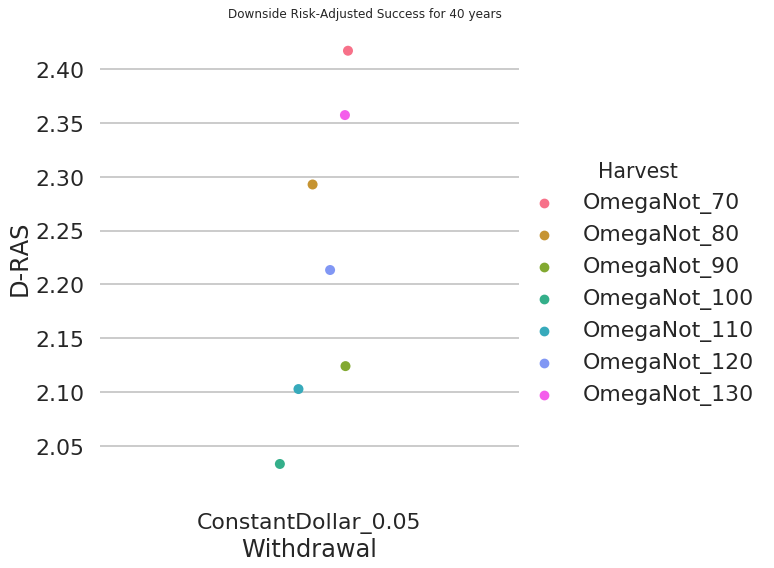

In [23]:
for withdraw in HardWithdraws:
    g = seaborn.catplot(x='Withdrawal',
                        y='D-RAS',
                        height=8,
                        hue='Harvest',
                        data=dras_df[(dras_df['Length'] == 40)
                                     & (dras_df['Harvest'].isin(JustOmegas))
                                     & (dras_df['Withdrawal'] == withdraw)],
                        s=10,
                        palette=PALETTE_OMEGAS
                       )
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle('Downside Risk-Adjusted Success for 40 years')

## Coverage Ratio

Text(0.5, 0.98, 'Coverage Ratio for 30 years')

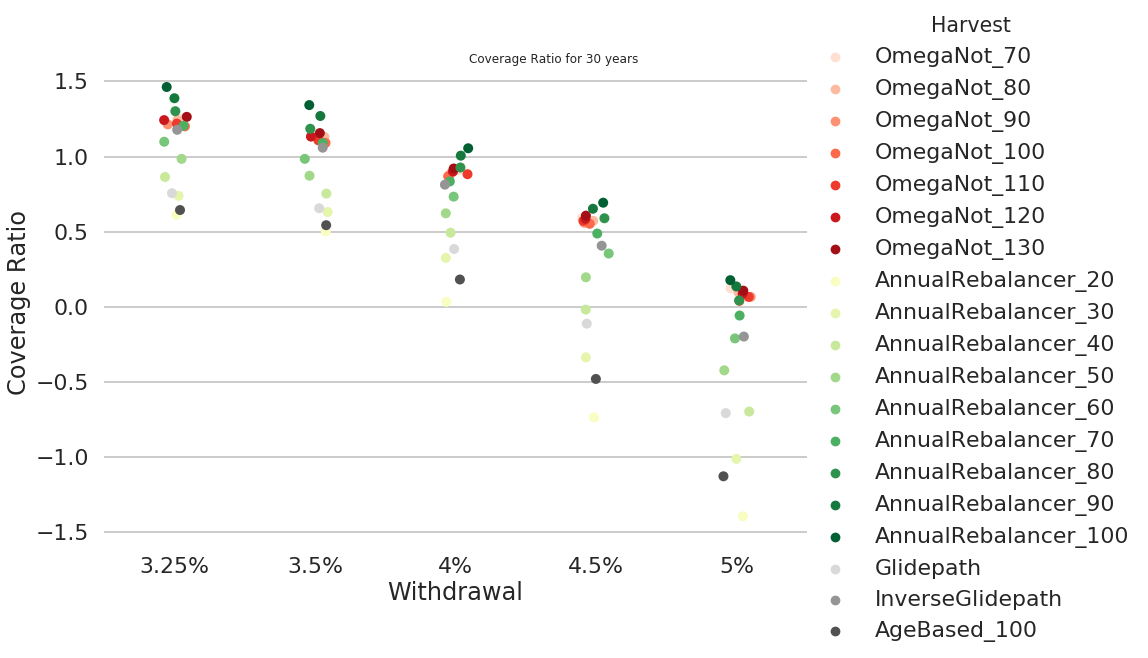

In [24]:
g = seaborn.catplot(x='Withdrawal',
                    y='Coverage Ratio',
                    height=8,
                    hue='Harvest',
                    data=dras_df[dras_df['Length'] == 30],
                    aspect=1.5,
                    s=10
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Coverage Ratio for 30 years')

Text(0.5, 0.98, 'Coverage Ratio for 30 years')

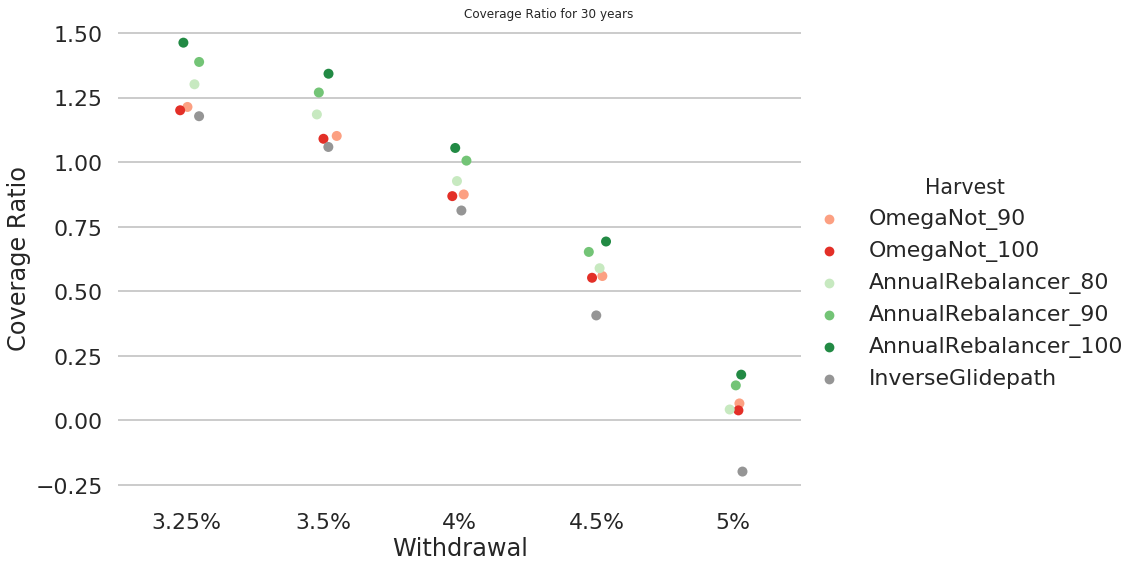

In [25]:
g = seaborn.catplot(x='Withdrawal',
                    y='Coverage Ratio',
                    height=8,
                    hue='Harvest',
                    data=dras_df[(dras_df['Length'] == 30) & (dras_df['Harvest'].isin(FewerHarvests))],
                    aspect=1.5,
                    s=10,
                    palette=GoodPalette
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Coverage Ratio for 30 years')

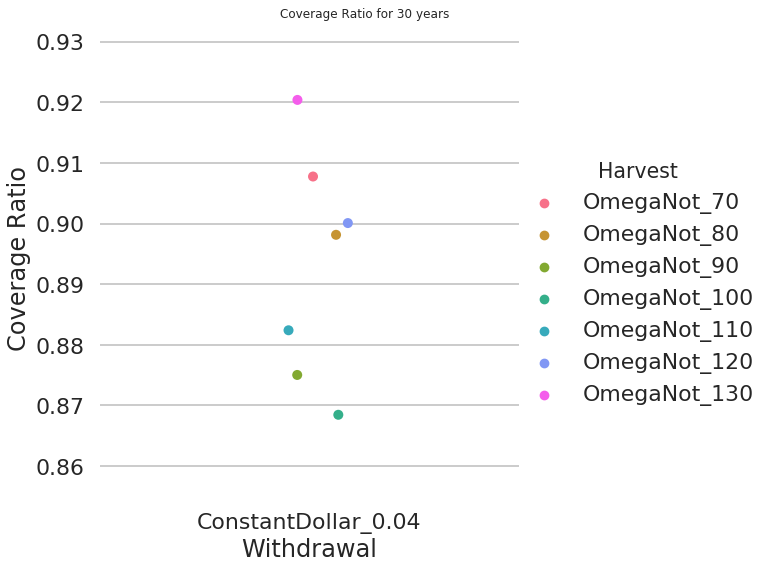

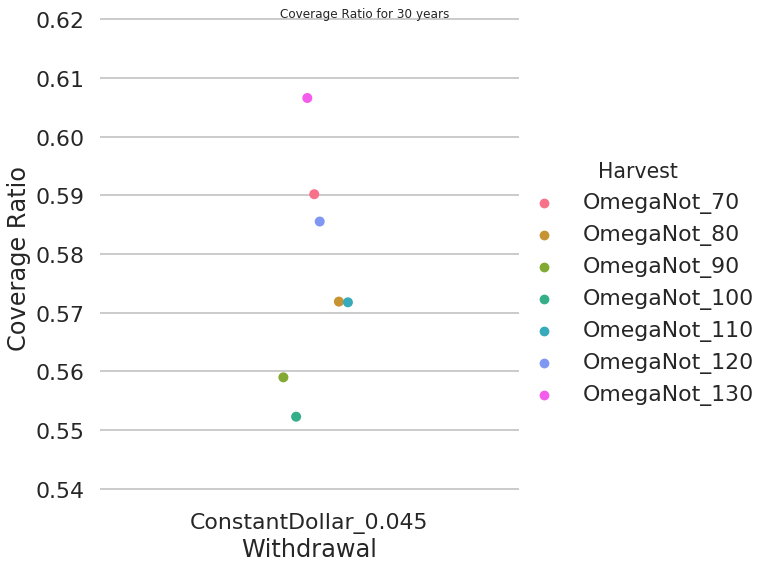

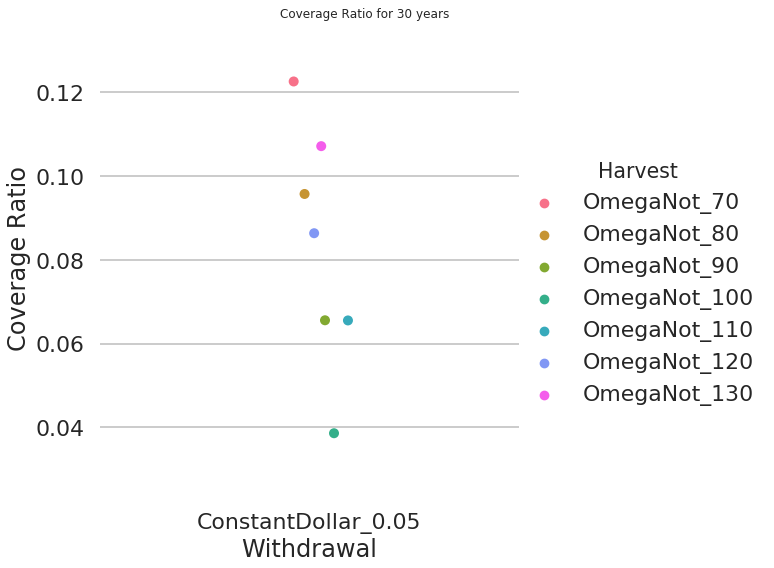

In [26]:
for withdraw in HardWithdraws:
    g = seaborn.catplot(x='Withdrawal',
                        y='Coverage Ratio',
                        height=8,
                        hue='Harvest',
                        data=dras_df[(dras_df['Length'] == 30)
                                     & (dras_df['Harvest'].isin(JustOmegas))
                                     & (dras_df['Withdrawal'] == withdraw)
                                    ],
                        s=10,
                        palette=PALETTE_OMEGAS
                       )
    g.despine(left=True, bottom=True, offset=20)
#    g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
    g.fig.suptitle('Coverage Ratio for 30 years')

# Ulcer Index

In [27]:
def run():
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'Ulcer Index (Avg)'])

    i = 0
    for (years, harvest, withdraw) in Combos:
        series = run_calc(harvest, withdraw, years, calc_ulcer)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.mean())
        i += 1
    return df
ulcer_df = run()

Text(0.5, 0.98, 'Ulcer Index (Avg) for 30 years')

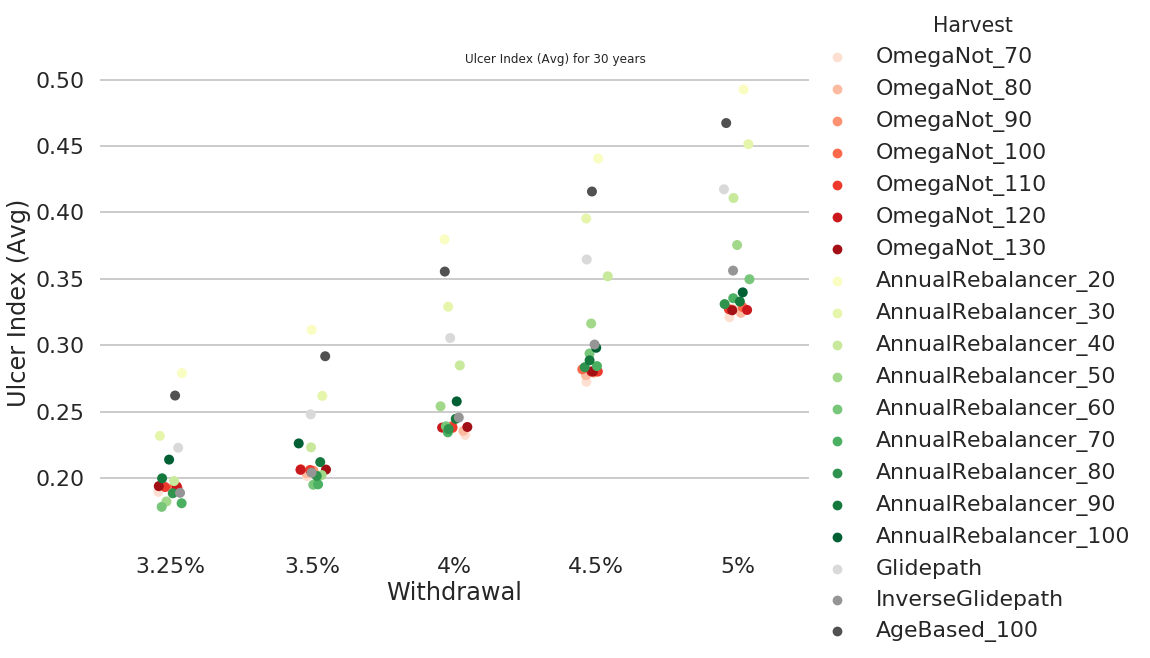

In [28]:
g = seaborn.catplot(x='Withdrawal',
                    y='Ulcer Index (Avg)',
                    height=8,
                    hue='Harvest',
                    data=ulcer_df[ulcer_df['Length'] == 30],
                    aspect=1.5,
                    s=10
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Ulcer Index (Avg) for 30 years')

Text(0.5, 0.98, 'Ulcer Index (Avg) for 30 years')

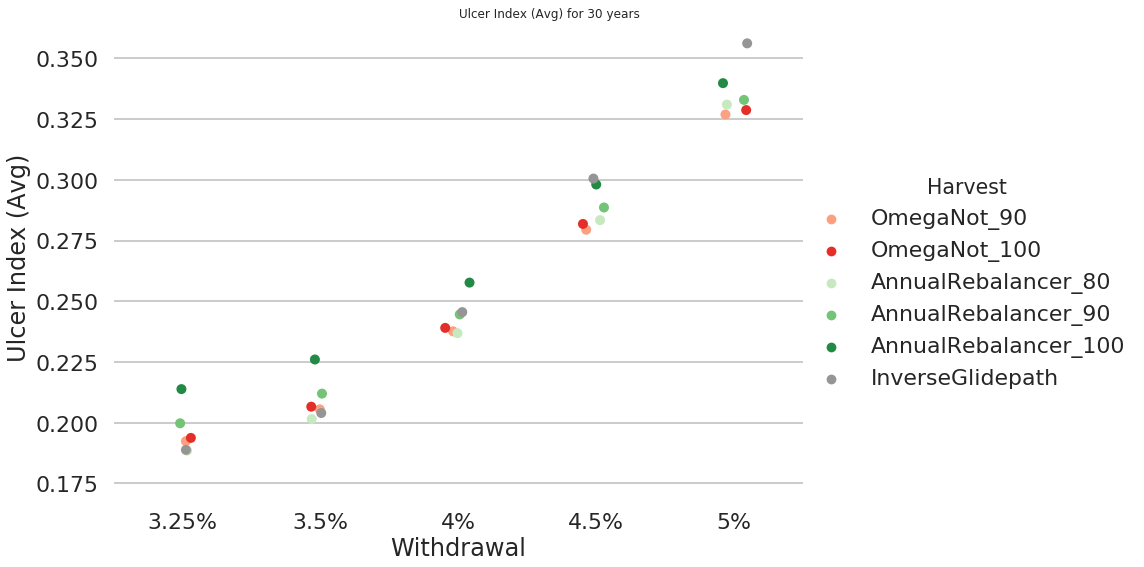

In [29]:
g = seaborn.catplot(x='Withdrawal',
                    y='Ulcer Index (Avg)',
                    height=8,
                    hue='Harvest',
                    data=ulcer_df[(ulcer_df['Length'] == 30) & (ulcer_df['Harvest'].isin(FewerHarvests))],
                    aspect=1.5,
                    s=10,
                    palette=GoodPalette
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Ulcer Index (Avg) for 30 years')

Text(0.5, 0.98, 'Ulcer Index (Avg) for 30 years')

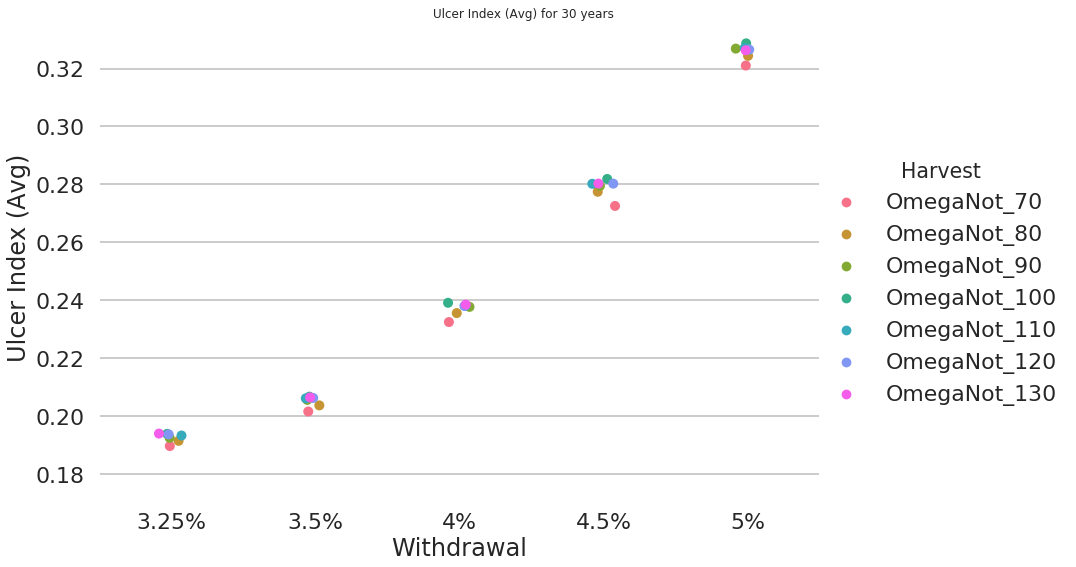

In [30]:
GoodRebalancers = []
GoodOmegas = [n.__name__ for n in Omegas]
FewerHarvests = GoodRebalancers + GoodOmegas

g = seaborn.catplot(x='Withdrawal',
                    y='Ulcer Index (Avg)',
                    height=8,
                    hue='Harvest',
                    data=ulcer_df[(ulcer_df['Length'] == 30) & (ulcer_df['Harvest'].isin(FewerHarvests))],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_OMEGAS
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Ulcer Index (Avg) for 30 years')

Text(0.5, 0.98, 'Ulcer Index (Avg) for 30 years')

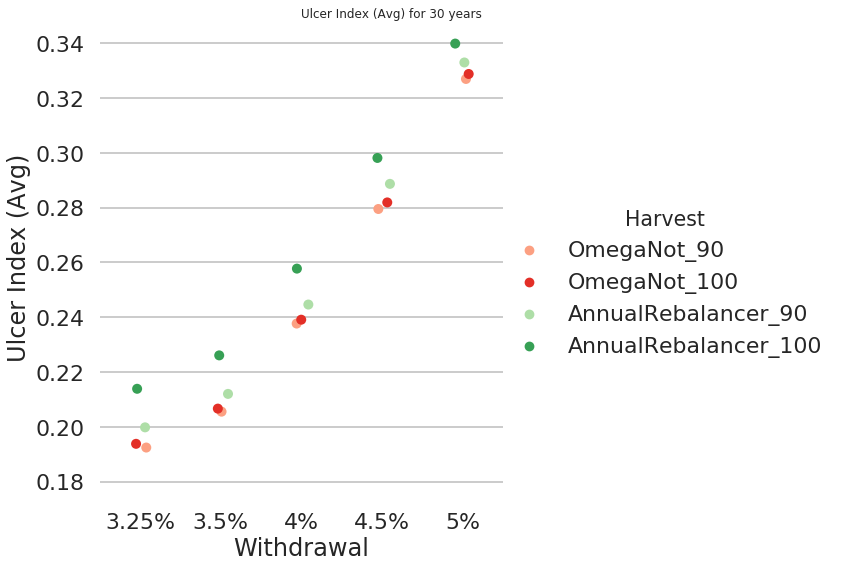

In [31]:
GoodRebalancers = ['AnnualRebalancer_100', 'AnnualRebalancer_90']
GoodOmegas = ['OmegaNot_100', 'OmegaNot_90']
FewerHarvests = GoodRebalancers + GoodOmegas
Palette = seaborn.color_palette("Reds", len(GoodOmegas)) + seaborn.color_palette("Greens", len(GoodRebalancers))

g = seaborn.catplot(x='Withdrawal',
                    y='Ulcer Index (Avg)',
                    height=8,
                    hue='Harvest',
                    data=ulcer_df[(ulcer_df['Length'] == 30) & (ulcer_df['Harvest'].isin(FewerHarvests))],
                    s=10,
                    palette=Palette
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.fig.suptitle('Ulcer Index (Avg) for 30 years')

# Average Bond holding

Are we getting better results simply because we're holding more bonds?

In [32]:
OmegaCombos = list(itertools.product(Lengths, Omegas, Withdraw_Strategies))

def run():
    df = pandas.DataFrame(index=range(0, len(OmegaCombos)), columns=['Length', 'Harvest', 'Withdrawal', 'Bond Pct (Avg)'])

    i = 0
    for (years, harvest, withdraw) in OmegaCombos:
        series = run_calc(harvest, withdraw, years, calc_bond_pct)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.mean())
        i += 1
    return df
bond_pct_df = run()

Text(0.5, 0.98, 'Bond Pct (Avg) for 30 years')

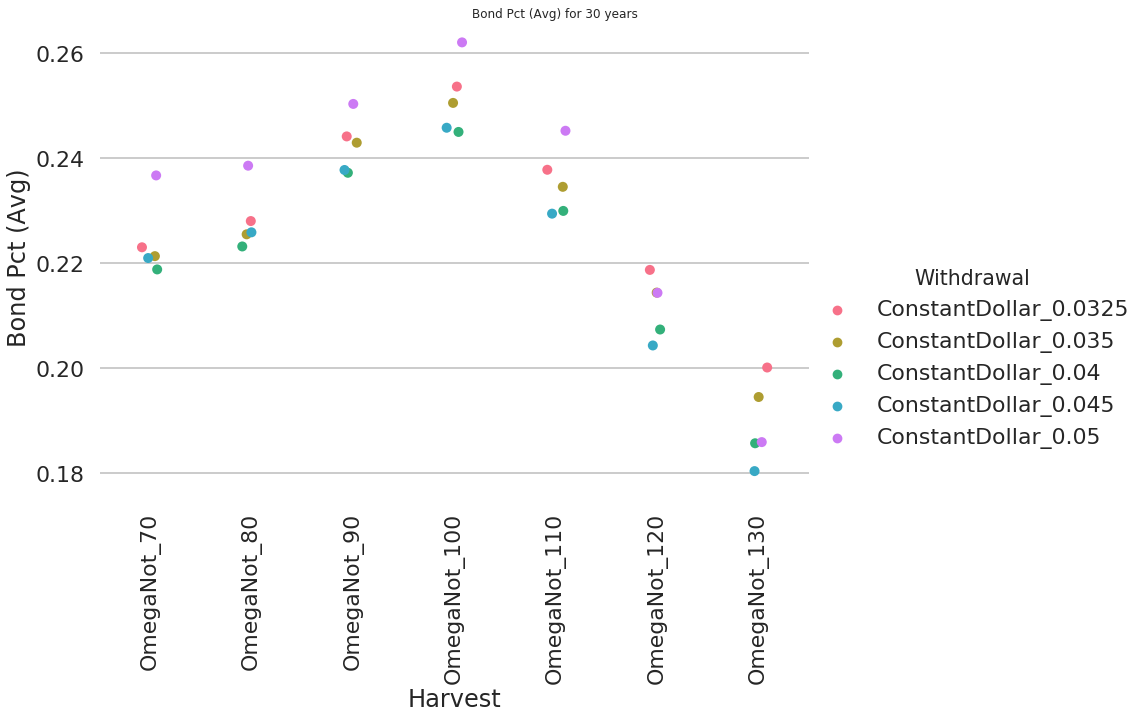

In [33]:
g = seaborn.catplot(x='Harvest',
                    y='Bond Pct (Avg)',
                    height=8,
                    hue='Withdrawal',
                    data=bond_pct_df[(bond_pct_df['Length'] == 30)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_WITHDRAW
                   )
g.despine(left=True, bottom=True, offset=20)
#g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.set_xticklabels(rotation=90)
g.fig.suptitle('Bond Pct (Avg) for 30 years')

Text(0.5, 0.98, 'Bond Percentage by Cohort OmegaNot_100 - ConstantDollar_0.0325 - 30')

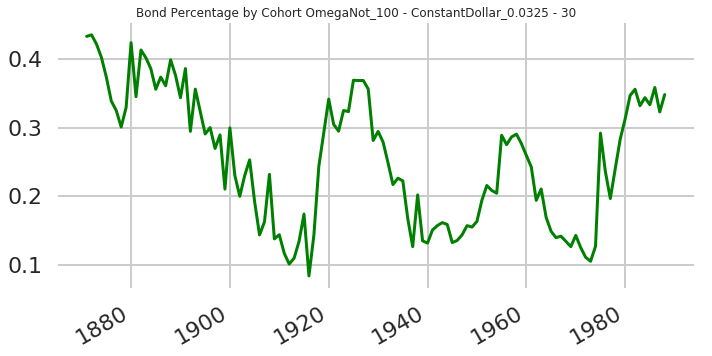

In [34]:
omega = Omegas[3]
withdraw = Withdraw_Strategies[0]
years = Lengths[0]
series = run_calc(omega, withdraw, years, calc_bond_pct)
g = seaborn.relplot(
    data=series,
    kind='line',
    color='Green',
    aspect=2,
    )
g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
#print(omega.__name__, '-', withdraw.__name__, '-', years)
g.fig.suptitle('Bond Percentage by Cohort %s - %s - %s' % (omega.__name__, withdraw.__name__, years))

## Equivalent bond holdings

Text(0.5, 0.98, 'MSWR with equivalent bond holding ConstantDollar_0.0325 - 40')

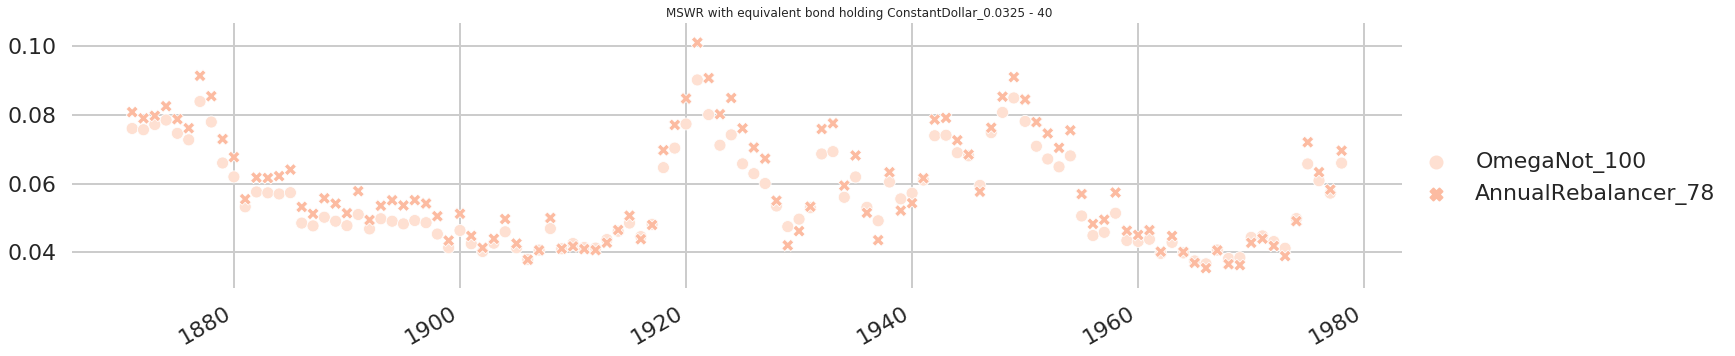

In [35]:
omega = Omegas[3]
withdraw = Withdraw_Strategies[0]
years = Lengths[1]
series_omega = run_calc(omega, withdraw, years, calc_pwa0)

equivalent_pct = bond_pct_df.query('Length == %s & Harvest == "%s" & Withdrawal == "%s"' % (years, omega.__name__, withdraw.__name__))["Bond Pct (Avg)"].item()
rebalancer = harvesting.make_rebalancer(D(1 - equivalent_pct))
series_reb = run_calc(rebalancer, withdraw, years, calc_pwa0)
df_comparison = pandas.DataFrame({omega.__name__: series_omega, rebalancer.__name__: series_reb})
g = seaborn.relplot(
    data=df_comparison,
    aspect=4,
    )
g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle('MSWR with equivalent bond holding %s - %s' % (withdraw.__name__, years))

Average when Omega wins 
--------
 OmegaNot_100           0.045101
AnnualRebalancer_78    0.043471
dtype: float64 


Min when Omega wins 
--------
 OmegaNot_100           0.036682
AnnualRebalancer_78    0.035431
dtype: float64


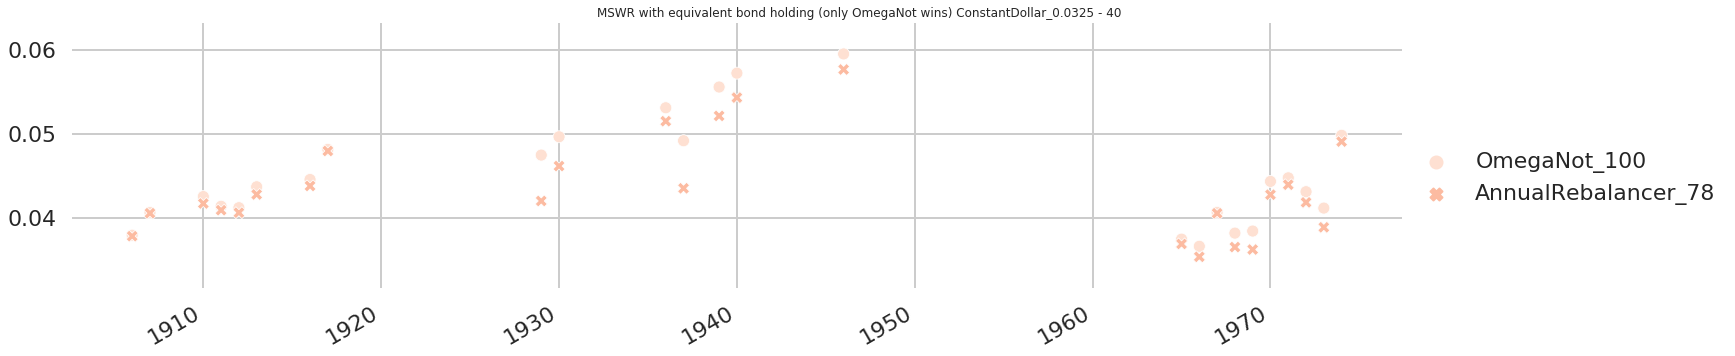

In [36]:
omega_wins = df_comparison[df_comparison[omega.__name__] > df_comparison[rebalancer.__name__]]
g = seaborn.relplot(
    data=omega_wins,
    aspect=4,
    )
g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle('MSWR with equivalent bond holding (only OmegaNot wins) %s - %s' % (withdraw.__name__, years))

print('Average when Omega wins', '\n--------\n', omega_wins.mean(), '\n\n')
print('Min when Omega wins', '\n--------\n', omega_wins.min())

Omega beats Rebalance by (avg) 0.16304189290831828
Omega beats Rebalance by (max) 0.5646465552420826396993032040
Rebalance beats Omega by (avg) -0.4542939635518568
Rebalance beats Omega by (max) -1.085958558653893045913920849


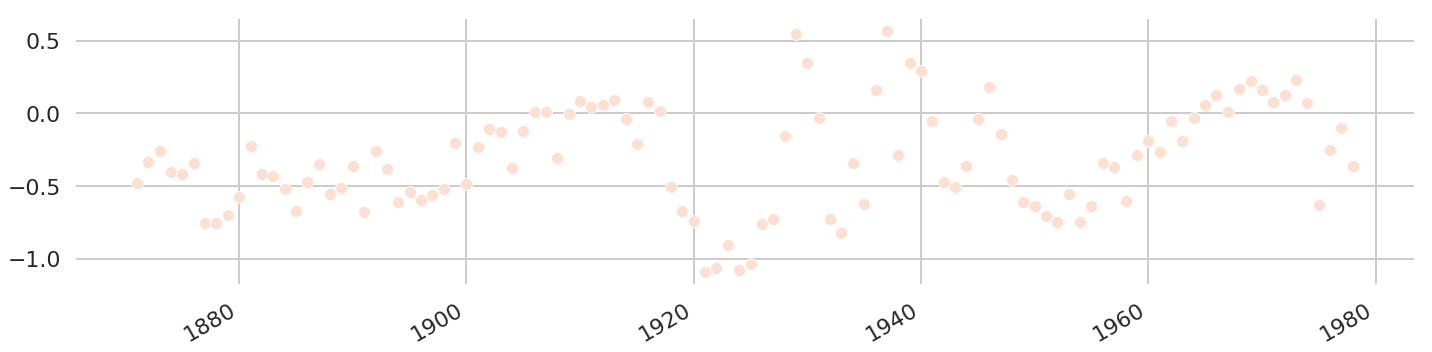

In [37]:
omega_diff =  (df_comparison[omega.__name__] - df_comparison[rebalancer.__name__]).apply(lambda x: x*100)

g = seaborn.relplot(
    data=omega_diff,
    aspect=4,
    )
g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
#g.fig.suptitle('MSWR with equivalent bond holding %s - %s' % (withdraw.__name__, years))

print('Omega beats Rebalance by (avg)', omega_diff[omega_diff > 0].mean())
print('Omega beats Rebalance by (max)', omega_diff[omega_diff > 0].max())
print('Rebalance beats Omega by (avg)', omega_diff[omega_diff < 0].mean())
print('Rebalance beats Omega by (max)', omega_diff[omega_diff < 0].min())

# Single Year Highest Withdrawal Rate

Look at current withdrawl rates. i.e. how much money are we pulling from the current portfolio. A higher number is more stressful.
Are we getting better results with more stress?

In [38]:
def run():
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'Max Withdraw % (Avg)'])

    i = 0
    for (years, harvest, withdraw) in Combos:
        series = run_calc(harvest, withdraw, years, calc_max_wd)
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.mean())
        i += 1
    return df

max_wd_df = run()

Text(0.5, 0.98, 'Single Year Highest Withdrawal over 40 years')

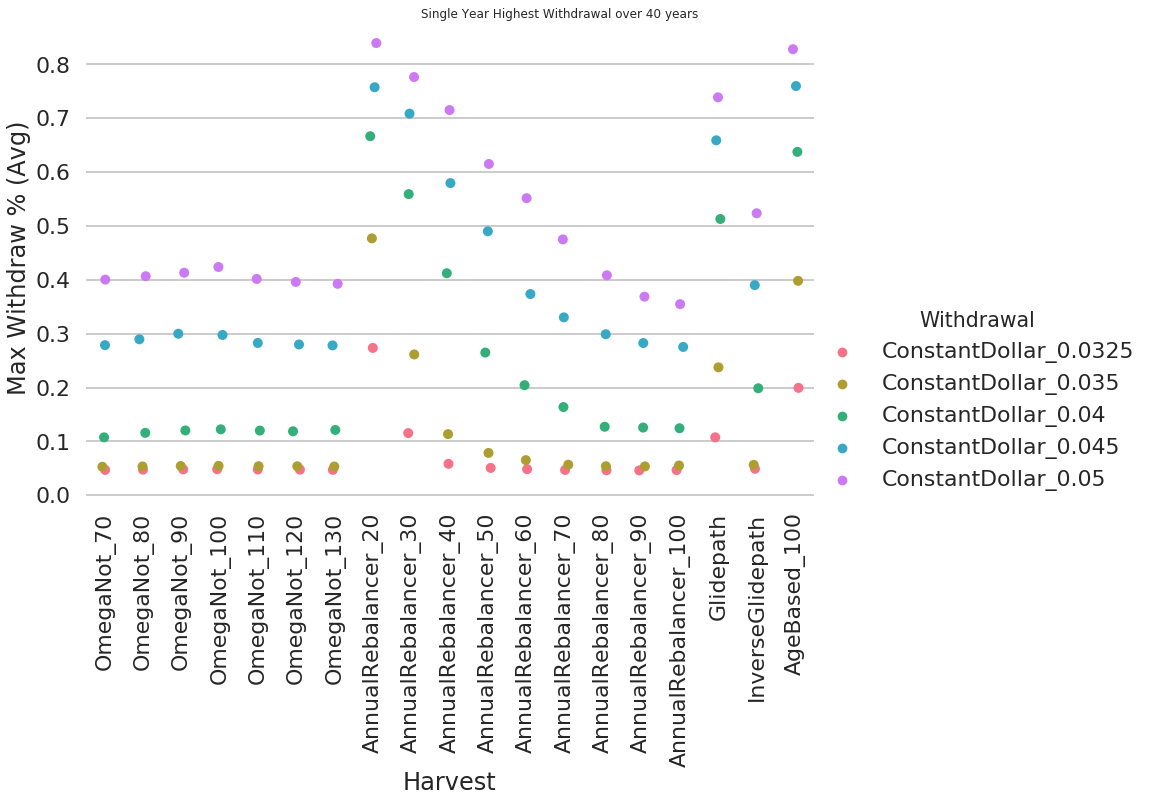

In [39]:
g = seaborn.catplot(x='Harvest',
                    y='Max Withdraw % (Avg)',
                    height=8,
                    hue='Withdrawal',
                    data=max_wd_df[(max_wd_df['Length'] == 40)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_WITHDRAW
                   )
g.despine(left=True, bottom=True, offset=20)
#g.set_xticklabels(['3.25%', '3.5%', '4%', '4.5%', '5%'])
g.set_xticklabels(rotation=90)
g.fig.suptitle('Single Year Highest Withdrawal over 40 years')

# Certainty-Equivalent Withdrawals (VPW)

In [40]:
def run():
    Combos = list(itertools.product(Lengths, Harvest_Strategies))
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'CEW (Avg)', 'CEW (Min)'])

    i = 0
    for (years, harvest) in Combos:
        withdraw = withdrawal.make_vpw(years)
        series = run_calc(harvest, withdraw, years, calc_cew)
        # Should this be mean? Or also use CEW calculation?
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.mean(), series.min())
        i += 1
    return df

cew_df = run()

Text(0.5, 0.98, 'Certainty-Equivalent Withdrawals (Avg) using VPW')

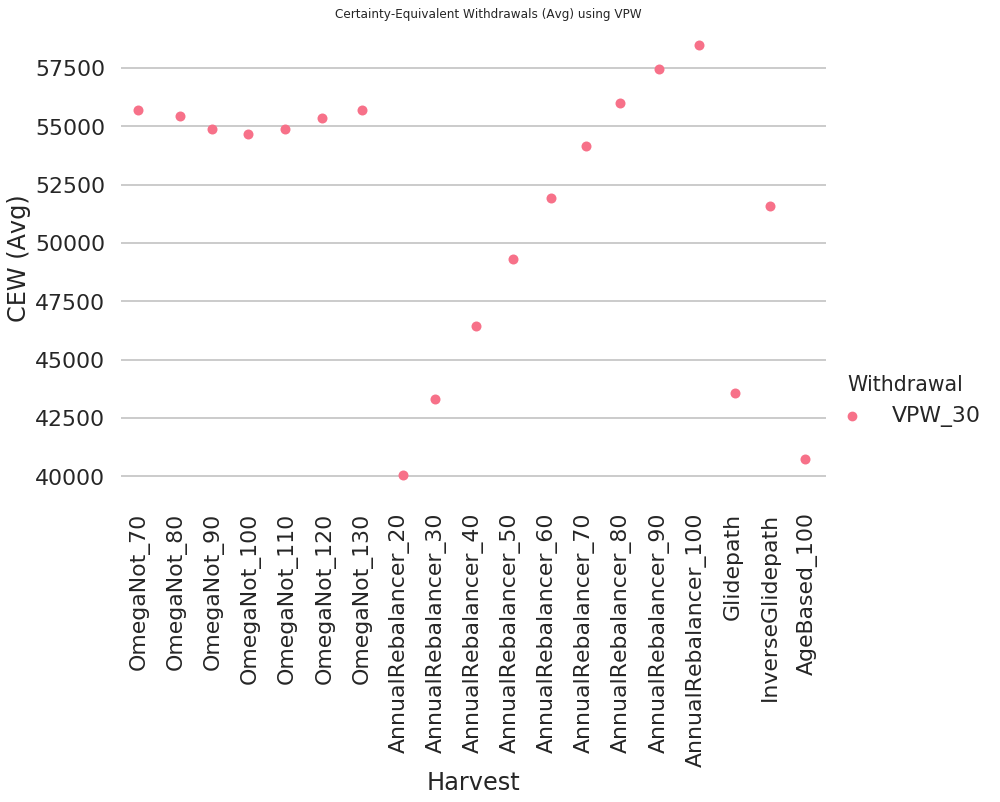

In [41]:
g = seaborn.catplot(x='Harvest',
                    y='CEW (Avg)',
                    height=8,
                    hue='Withdrawal',
                    data=cew_df[(cew_df['Length'] == 30)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_HARVEST
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(rotation=90)
g.fig.suptitle('Certainty-Equivalent Withdrawals (Avg) using VPW')

Text(0.5, 0.98, 'Certainty-Equivalent Withdrawals (Min) using VPW')

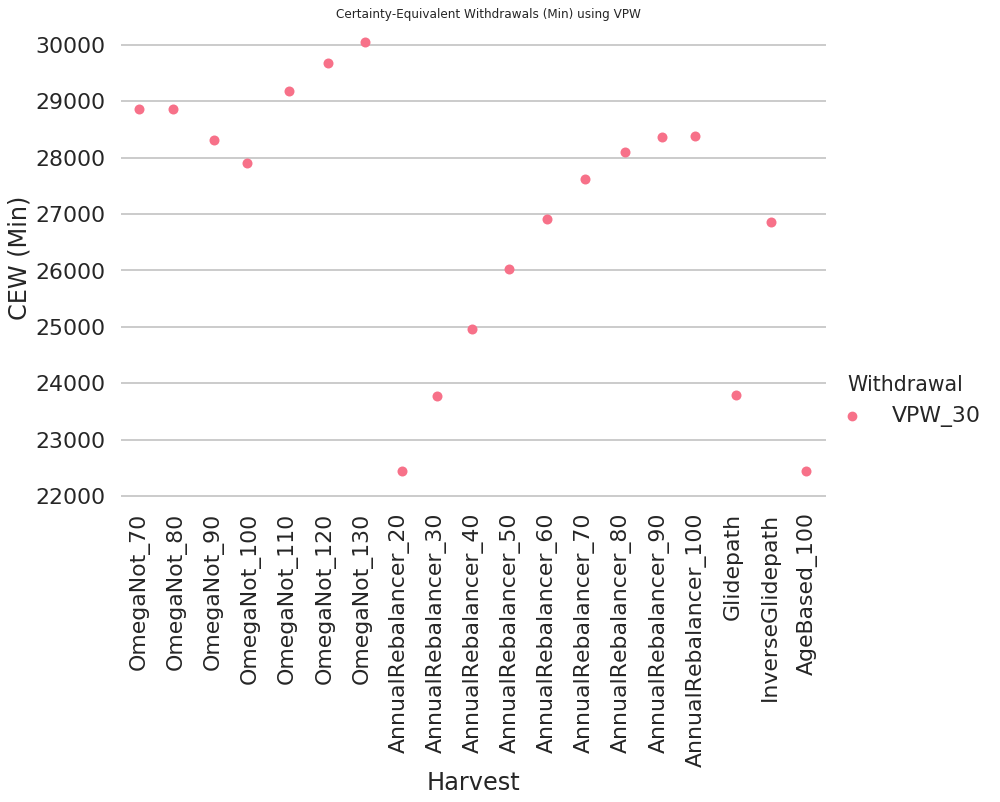

In [42]:
g = seaborn.catplot(x='Harvest',
                    y='CEW (Min)',
                    height=8,
                    hue='Withdrawal',
                    data=cew_df[(cew_df['Length'] == 30)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_HARVEST
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(rotation=90)
g.fig.suptitle('Certainty-Equivalent Withdrawals (Min) using VPW')

In [43]:
def run():
    Combos = list(itertools.product(Lengths, Harvest_Strategies))
    df = pandas.DataFrame(index=range(0, len(Combos)), columns=['Length', 'Harvest', 'Withdrawal', 'HREFF4 (Avg)', 'HREFF4 (Min)'])

    i = 0
    for (years, harvest) in Combos:
        withdraw = withdrawal.make_vpw(years)
        series = run_calc(harvest, withdraw, years, calc_hreff)
        # Should this be mean? Or also use HREFF/CEW calculation?
        df.iloc[i] = (years, harvest.__name__, withdraw.__name__, series.median(), series.min())
        i += 1
    return df

hreff_df = run()

Text(0.5, 0.98, 'HREFF-4 (Avg) using VPW')

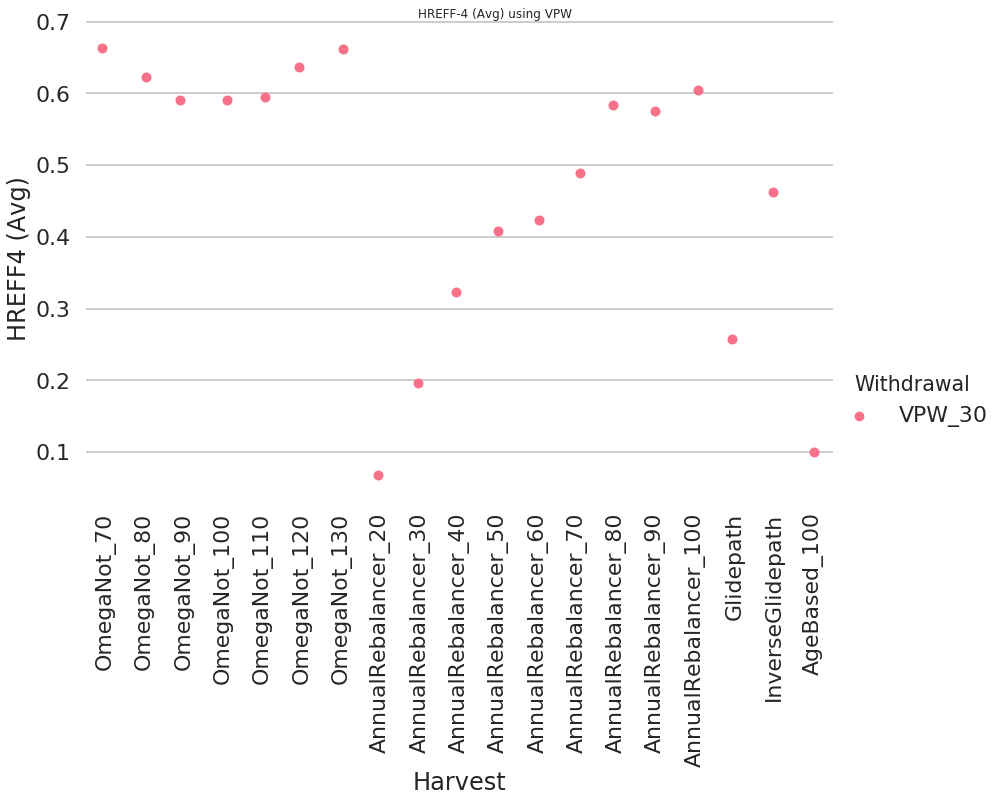

In [44]:
g = seaborn.catplot(x='Harvest',
                    y='HREFF4 (Avg)',
                    height=8,
                    hue='Withdrawal',
                    data=hreff_df[(hreff_df['Length'] == 30)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_HARVEST
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(rotation=90)
g.fig.suptitle('HREFF-4 (Avg) using VPW')

Text(0.5, 0.98, 'HREFF-4 (Min) using VPW')

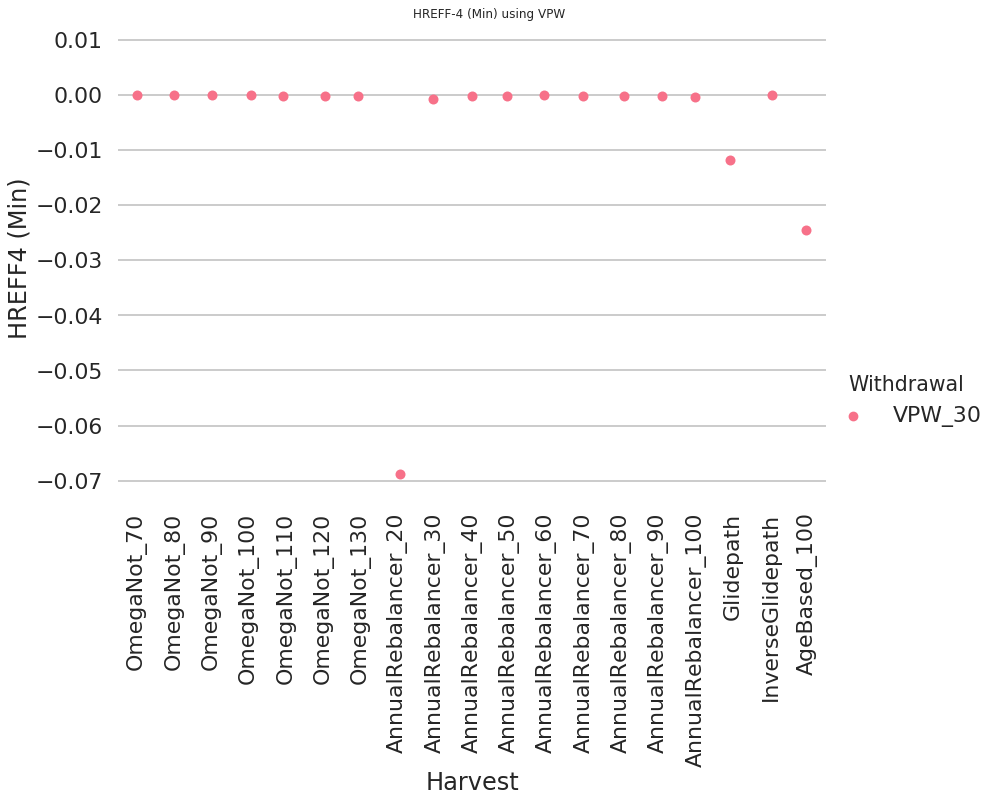

In [45]:
g = seaborn.catplot(x='Harvest',
                    y='HREFF4 (Min)',
                    height=8,
                    hue='Withdrawal',
                    data=hreff_df[(hreff_df['Length'] == 30)],
                    aspect=1.5,
                    s=10,
                    palette=PALETTE_HARVEST
                   )
g.despine(left=True, bottom=True, offset=20)
g.set_xticklabels(rotation=90)
g.fig.suptitle('HREFF-4 (Min) using VPW')

# Output everything to a single, big Excel file

In [46]:
xls = pandas.ExcelWriter('omega_all.xlsx', engine='xlsxwriter')

success_df.to_excel(xls, sheet_name='Failure Rate')
pwa0_df.to_excel(xls, sheet_name='MSWR')
pwa1_df.to_excel(xls, sheet_name='Perpetual Rate')
shortfall_years_df.to_excel(xls, sheet_name='Shortfall Years')
dras_df.to_excel(xls, sheet_name='DRAS & Coverage Ratio')
ulcer_df.to_excel(xls, sheet_name='Ulcer Index')
bond_pct_df.to_excel(xls, sheet_name='Bond Percentages')
max_wd_df.to_excel(xls, sheet_name='Highest Single Withdrawal')
cew_df.to_excel(xls, sheet_name='CEW')
hreff_df.to_excel(xls, sheet_name='HREFF4')

xls.save()